<h1>Two IsoClustering Algorithms</h1>

In [3]:
import numpy as np

In [4]:
def cluster(vertex, graph, alpha = 1, classified = None):
    n = graph.shape[0]  
    if(classified is None):
        classified = np.zeros(n)
    else:
        assert(len(classified) == n), "Length of classified does not match size of graph."
        classified = classified.astype(int)
        
    internal_weights = graph[vertex].astype(float)    
    degrees = np.sum(graph, axis = 1)
    perimeter = np.sum(internal_weights)      
    classified[vertex] = 1
    area = internal_weights[vertex]
    
    while (sum(classified) < n): 
        temp_perimeter = perimeter - 2*internal_weights + degrees
        temp_area = area + internal_weights
        ratios = temp_area / (temp_perimeter + 0.000001) 
        next_vertex = np.argmax(ratios * np.logical_not(classified))
        this_alpha = (area*temp_perimeter[next_vertex])/(perimeter*temp_area[next_vertex]) 
        if(this_alpha > alpha):
            break
        classified[next_vertex] = 1
        internal_weights += graph[next_vertex]
        perimeter = temp_perimeter[next_vertex]
        area = temp_area[next_vertex]

    return classified
            
A = np.array([[0,1,1,0,0,0],[1,0,1,0,0,0],[1,1,0,1,0,0],[0,0,1,0,1,1],[0,0,0,1,0,1],[0,0,0,1,1,0]])
this_cluster = cluster(0,A) 
this_cluster

array([ 1.,  1.,  1.,  0.,  0.,  0.])

In [5]:
def cluster2(vertex, graph, alpha = 0.5, classified = None):
    n = graph.shape[0]  
    if(classified is None):
        classified = np.zeros(n)
    else:
        assert(len(classified) == n), "Length of classified does not match size of graph."
        classified = classified.astype(int)
        
    internal_weights = graph[vertex].astype(float) 
    degrees = np.sum(graph, axis = 1)
    perimeter = np.sum(internal_weights)      
    classified[vertex] = 1
    area = internal_weights[vertex]
    
    while (sum(classified) < n): 
        temp_perimeter = perimeter - 2*internal_weights + degrees
        temp_area = area + internal_weights
        ratios = internal_weights/(degrees - internal_weights + 0.000001)
        next_vertex = np.argmax(ratios * np.logical_not(classified))

        if((1.0-alpha) * perimeter * (temp_area[next_vertex]-area) \
           < alpha * area * (temp_perimeter[next_vertex]-perimeter)):
            break

        classified[next_vertex] = 1
        internal_weights += graph[next_vertex]
        perimeter = temp_perimeter[next_vertex]
        area = temp_area[next_vertex]

    return classified
            
A = np.array([[0,1,1,0,0,0],[1,0,1,0,0,0],[1,1,0,1,0,0],[0,0,1,0,1,1],[0,0,0,1,0,1],[0,0,0,1,1,0]])
this_cluster = cluster2(0,A) 
this_cluster

array([ 1.,  1.,  1.,  0.,  0.,  0.])

From a user's perspective the only difference in these two algorithms is the range of $\alpha$.

In my algorithm, defined as cluster, $\alpha$ takes a range from 0 to infinity. Small values will generate small clusters, while large values will generate a single large cluster spanning all nodes.

In Haley's algorithm, defined as cluster2, $\alpha$ takes a range from 0 to 1. Small values will generate large clusters spanning all nodes, and values close to 1 will generate small clusters.

In Haley's original algorithm, the starting node was always the unclassified node with the highest degree on the graph. I've suppressed that. That means that the user has to supply the starting node (labeled as vertex in the arguments to the function).

Unlike Haley's original algorithm, both of these functions stop after finding one and only one cluster. This leaves the user with a couple of choices after finding the first cluster. If the user is interested in finding overlapping communities, then the user simply should run the clustering algorithm again on one of the unclassified nodes. If the user is interested in finding distinct, non-overlapping clusters, then the user should put the classified nodes found from the first community into the "classified" argument to the function. However, the user will need to be aware that the algorithm will return a vector with both the original nodes and the new nodes labeled as classified. Below, I've given an example of how to use the classified argument.

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


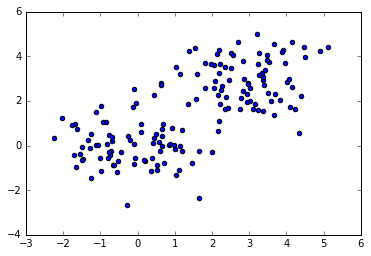

In [7]:
np.random.seed(145)
n = 160
x = randn(2*n).reshape(n,2)
for i in range(n//2,n):
    x[i][0] += 3
    x[i][1] += 3
def gauss_sim(x,y, sigma = 1):
    d = (x[0]-y[0])**2 + (x[1] - y[1])**2
    return np.exp(-d/(2*sigma))
adjacency = [[0 for i in range(n)] for j in range(n)]
for i in range(n):
    for j in range(i+1,n):
        g_s = gauss_sim(x[i],x[j])
        adjacency[i][j] = g_s
        adjacency[j][i] = g_s
scatter(x[:,0],x[:,1]);

Here is the example of using classified. And we use Haley's method of starting with the node with the highest degree.

We first cluster around one node, which returns us c1, then we find the node with the highest degree that has not already been classified.

We then cluster again around the new starting node, but we supply the previously clustered results to the "classified" argument (Again this is only necessary if you absolutely do not want overlapping clusters).

This returns us a new vector, but it is the vector of <b>all</b> classified points. So to find out what new points were classifeid, we must subtract c1 from c2.

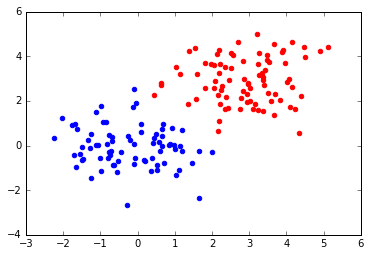

In [8]:
start = argmax(sum(adjacency,axis=1))
c1 = cluster2(start, np.array(adjacency))
start = argmax(sum(adjacency,axis=1)*np.logical_not(c1))
c2 = cluster2(start, np.array(adjacency), classified=c1)
c2 = c2 - c1

for i in range(len(c1)):
    if((c1[i] == 1) and (c2[i] == 0)):
        scatter(x[i][0], x[i][1], color="red")
    elif((c1[i] == 0) and (c2[i] == 1)):
        scatter(x[i][0], x[i][1], color="blue")
    else:
        scatter(x[i][0], x[i][1], color="black")
    

We can also simply skip that classified step to see the overlap:

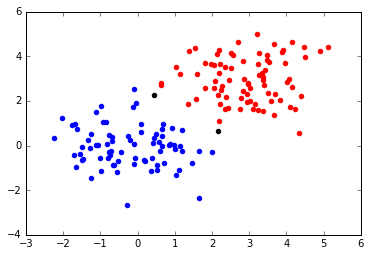

In [9]:
start = argmax(sum(adjacency,axis=1))
c1 = cluster2(start, np.array(adjacency))
start = argmax(sum(adjacency,axis=1)*np.logical_not(c1))
c2 = cluster2(start, np.array(adjacency))

for i in range(len(c1)):
    if((c1[i] == 1) and (c2[i] == 0)):
        scatter(x[i][0], x[i][1], color="red")
    elif((c1[i] == 0) and (c2[i] == 1)):
        scatter(x[i][0], x[i][1], color="blue")
    else:
        scatter(x[i][0], x[i][1], color="black")

And as we can see there are a few nodes that were claimed by both clusters.

Finally, I want to mention that there is a mathematical <b>bug</b> in both algorithms. Both algorithms assume that the graph is symmetric. However, when using K-nearest neighbors to generate the adjacency matrix, it is highly possible that asymmetries are introduced. If, however, the user uses the full adjacency matrix as I have done above then the adjacency matrix will be symmetric. 